In [1]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

# Прочитаем датасеты просмотров (hits) и визитов (visits)

In [2]:
df = pd.read_csv("site_data_visits.csv", delimiter=';')

c:\users\09944\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (32,45,46,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Получим основные сведения об исходном наборе данных

In [3]:
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123394 entries, 0 to 123393
Columns: 134 entries, ym:s:visitID to ym:s:offlineCallURL
dtypes: float64(11), int64(30), object(93)
memory usage: 408.2 MB


,ym:s:visitID,ym:s:counterID,ym:s:watchIDs,ym:s:date,ym:s:dateTime,ym:s:dateTimeUTC,ym:s:isNewUser,ym:s:startURL,ym:s:endURL,ym:s:pageViews,...,ym:s:impressionsProductVariant,ym:s:impressionsProductPrice,ym:s:impressionsProductCurrency,ym:s:impressionsProductCoupon,ym:s:offlineCallTalkDuration,ym:s:offlineCallHoldDuration,ym:s:offlineCallMissed,ym:s:offlineCallTag,ym:s:offlineCallFirstTimeCaller,ym:s:offlineCallURL
0,"2,37454E+18",24857816,"[2374542296120035191,2374556883040601975,23746...",04.05.2018,04.05.2018 23:09,04.05.2018 23:09,1,http://lenzabor.ru/,http://lenzabor.ru/tsenyi/,6,...,[],[],[],[],[],[],[],[],[],[]
1,"1,80536E+19",24857816,"[18053553872993259407,18053565303429014250,180...",02.01.2018,02.01.2018 18:21,02.01.2018 18:21,1,http://lenzabor.ru/,http://lenzabor.ru/photos/foto-zaborov-iz-meta...,9,...,[],[],[],[],[],[],[],[],[],[]
2,"5,6246E+18",24857816,"[5624597053286321553,5624657149761359519]",25.09.2018,25.09.2018 11:02,25.09.2018 11:02,0,http://lenzabor.ru/,http://lenzabor.ru/,2,...,[],[],[],[],[],[],[],[],[],[]
3,"1,61896E+18",24857816,[1618959677078900425],31.03.2016,31.03.2016 14:30,31.03.2016 14:30,0,http://lenzabor.ru/kalkulyator-rascheta-stoimo...,http://lenzabor.ru/kalkulyator-rascheta-stoimo...,1,...,[],[],[],[],[],[],[],[],[],[]
4,"2,39011E+18",24857816,[2390111394919876378],04.05.2016,04.05.2016 15:39,04.05.2016 15:39,1,http://lenzabor.ru/kalkulyator-rascheta-stoimo...,http://lenzabor.ru/kalkulyator-rascheta-stoimo...,1,...,[],[],[],[],[],[],[],[],[],[]


# Исследуем форму и размер исходных данных

In [4]:
shape = df.shape
volume = shape[0]*shape[1]

print('Размер файла site_data_visits.csv: {} MB\nФорма файла исходного датафрейма: {}\nОбщий объем исходного датафрейма: {}'
      .format(os.path.getsize('site_data_visits.csv') >> 10, shape, volume)) 


Размер файла site_data_visits.csv: 92321 MB
Форма файла исходного датафрейма: (123394, 134)
Общий объем исходного датафрейма: 16534796


# Удалим пустые колонки

In [5]:
df_less = df.dropna(axis=1, thresh=6)

# Удалим колонки с единственным уникальным значением 

In [6]:
# drop_list = ['ym:pv:watchID', 'ym:pv:lastTrafficSource', 'ym:pv:lastSocialNetworkProfile', 'ym:pv:UTMSource']
drop_list = []

def check_unique():
    for title in list(df_less):
        if df_less[title].nunique() <= 1:
            drop_list.append(title)

check_unique()

df_less.drop(drop_list, axis='columns', inplace=True)

c:\users\09944\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Отобразим кол-во пустых ячеек

values    37.2
dtype: float64


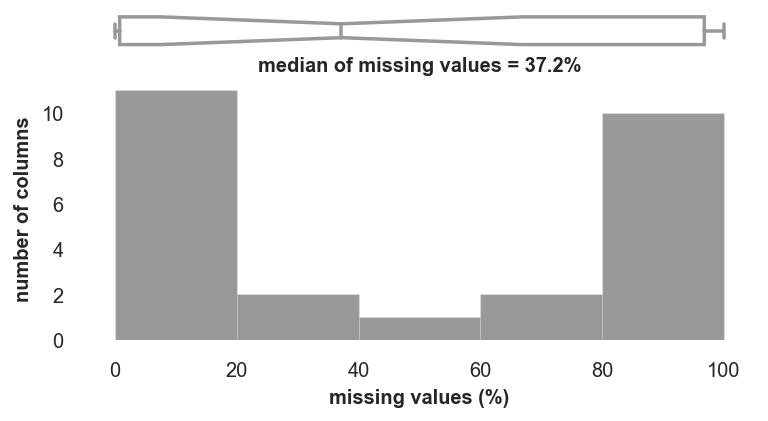

In [7]:
# Создаем словарь с % пропущеннных значений по каждоу признаку
null_cell = {}

for column in df_less:
  percent_count_nan = round(df_less[column].isnull().sum(axis = 0) / len(df_less[column]) * 100, 2)
  if percent_count_nan > 0:
      null_cell[column] = percent_count_nan
s = pd.Series(null_cell, name='DateValue')

# Визуализируем данные
df = pd.DataFrame({'index':s.index, 'values':s.values})

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.35, 2.65)}, figsize=(6, 3), dpi= 144)
 
# Add a graph in each part
sns.boxplot(df["values"], ax=ax_box, notch = True, color="white", saturation = .15)
sns.distplot(df["values"], kde=False, ax=ax_hist, color="black", bins=5)
 
# Remove x axis name for the boxplot
ax_hist.set_xlabel('missing values (%)', fontsize=10, fontweight="bold")
ax_box.set_xlabel('median of missing values = ' + str(df.median()[0]) + '%', fontsize=10, fontweight="bold")
ax_hist.set_ylabel('number of columns', fontsize=10, fontweight="bold")

print(df.median())

# print(df)

# f, ax = plt.subplots(figsize=(8, 2), dpi= 144)
# labels = ax.get_xticklabels()
# ax.set_xticklabels(labels, rotation=30, fontsize=8)
# plt.yticks(fontsize=6)
# ax = sns.countplot(x="values", data=df, color="c")
# ax.set_xlabel('% отсутствующих значений', fontsize=8, fontweight="bold")
# ax.set_ylabel('Количество столбцов', fontsize=8, fontweight="bold")


# Форма и размер нового датафрейма, % потери данных после удаения пустых значений

In [8]:
shape_less = df_less.shape
volume_less = shape_less[0]*shape_less[1]

print('Форма датафрейма после удаления: {}\nОбщий объем датафрейма после удаления: {}\nОсталось данных: {}%'
      .format(shape_less, volume_less, abs((round(1 - volume_less / volume * 100)))))

Форма датафрейма после удаления: (123394, 78)
Общий объем датафрейма после удаления: 9624732
Осталось данных: 57%


# Изменим тип данных всех колонок на строковые

In [9]:
df_less_fill = df_less[:].astype(str)

# Заполним пропущенные значения самым популярным категориальным признаком из каждой колонки

In [10]:
data_describe = df_less_fill.describe(include=[object])
for c in df_less_fill:
    df_less_fill[c] = df_less_fill[c].fillna(data_describe[c]['top'])

# Оптимизируем данные, преобразовав тип object на category, и измерим потребление памяти

In [11]:
df_less_fill.info(memory_usage = 'deep')
df_less_fill = df_less_fill.astype('category')
df_less_fill.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123394 entries, 0 to 123393
Data columns (total 78 columns):
ym:s:visitID                       123394 non-null object
ym:s:watchIDs                      123394 non-null object
ym:s:date                          123394 non-null object
ym:s:dateTime                      123394 non-null object
ym:s:dateTimeUTC                   123394 non-null object
ym:s:isNewUser                     123394 non-null object
ym:s:startURL                      123394 non-null object
ym:s:endURL                        123394 non-null object
ym:s:pageViews                     123394 non-null object
ym:s:visitDuration                 123394 non-null object
ym:s:bounce                        123394 non-null object
ym:s:ipAddress                     123394 non-null object
ym:s:regionCountry                 123394 non-null object
ym:s:regionCity                    123394 non-null object
ym:s:regionCountryID               123394 non-null object
ym:s:regionCityID  

# Узнаем сколько столбцов содержать более 50% уникальных значений

In [12]:
def print_value(value):
    if value > 50:
        print('Для ' + title + ' уникальных значений: ' + str(round(value)) + '%')

for title in list(df_less_fill):
      unique_percent = df_less_fill[title].nunique() / len(df_less_fill[title]) * 100
      print_value(unique_percent)

Для ym:s:visitID уникальных значений: 81%
Для ym:s:watchIDs уникальных значений: 100%
Для ym:s:dateTime уникальных значений: 95%
Для ym:s:dateTimeUTC уникальных значений: 95%
Для ym:s:clientID уникальных значений: 63%


# Выполним векторизацию:


One-hot encoding

In [13]:
# df_onehot_encoder = OneHotEncoder(sparse=True)

# encoded_categorical_columns = pd.DataFrame(df_onehot_encoder.fit_transform(df_less_fill))
# df_less_fill.info()
# encoded_categorical_columns.head()
# pandas_profiling.ProfileReport(encoded_categorical_columns)

FeatureHasher encoding

In [14]:
h = FeatureHasher(n_features=461486, input_type="string")
f = h.transform(df_less_fill)
f.toarray()
encoded_categorical_columns = f.toarray()

# Отобразим матрицу корреляции категориальных признаков

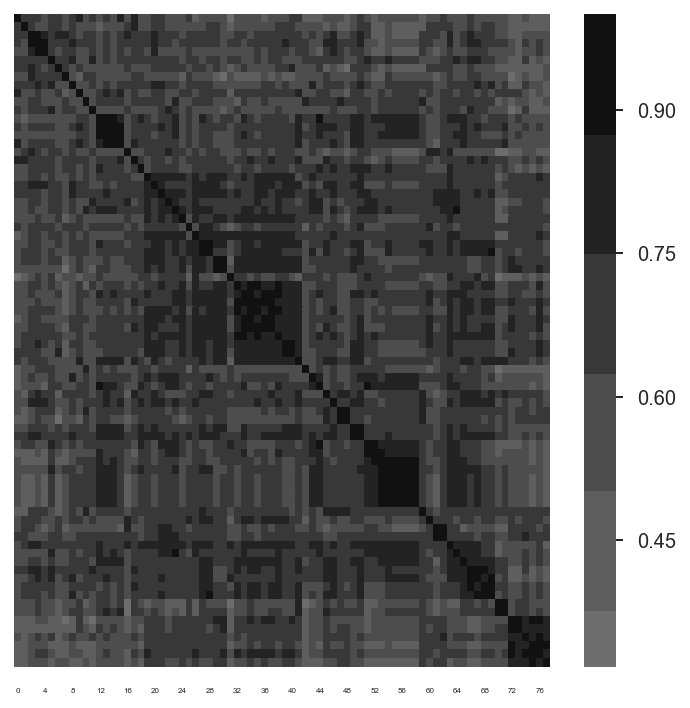

In [15]:
# palette_color = sns.color_palette("BrBG", 12)
palette_color = sns.color_palette(palette='Greys', n_colors=16)

encoded_categorical_columns = pd.DataFrame(encoded_categorical_columns).transpose()
plt.figure(figsize=(6,6), dpi= 144)
sns.heatmap(
    encoded_categorical_columns.corr(), 
    cmap=palette_color, 
    center=0, 
    annot=False,
    xticklabels=4,
    yticklabels=False,
    # linewidths=.05,
    # linecolor='white'
    )

plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.show()

# Отобразим матрицу корреляции первых 15 категориальных признаков

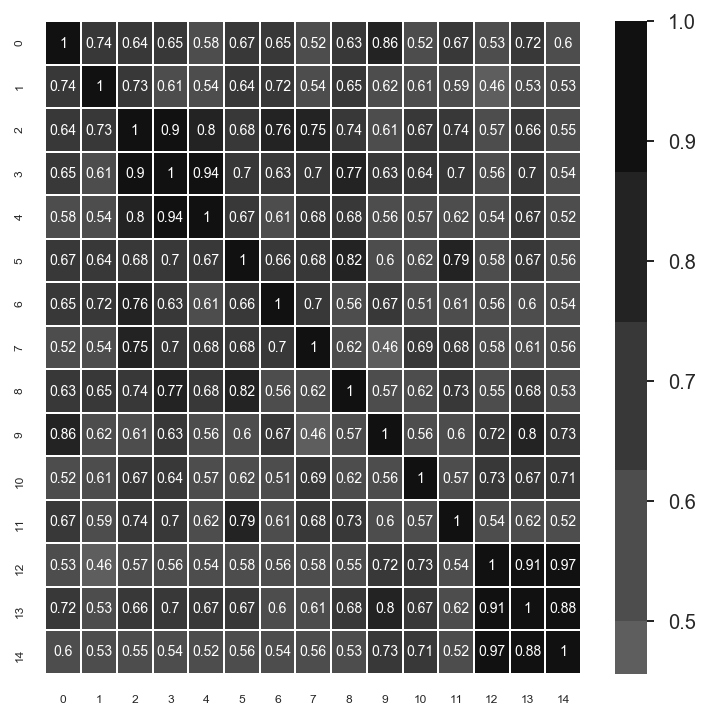

In [16]:
plt.figure(figsize=(6,6), dpi= 144)
sns.heatmap(
    encoded_categorical_columns.iloc[:,:15].corr(method='pearson'),
    cmap=palette_color, 
    center=0, 
    annot=True,
    annot_kws={"size": 7},
    linewidths=.5,
    linecolor='white',
    )

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

# Рассчитаем корреляцию для двух категориальных признаков через коэффициент Крамера

In [17]:
def cramers_corrected_stat(x,y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

cramers_corrected_stat(df_less_fill['ym:s:regionCityID'], df_less_fill['ym:s:regionCity'])

0.999984

# Выделим числовые и категориальные признаки, и изучим их:

In [18]:
# print(df.describe(include=[object]))
# print(df.describe(exclude=[object]))
# 
# categorical_columns = [c for c in df_less.columns if df_less[c].dtype.name == 'object']
# numerical_columns   = [c for c in df_less.columns if df_less[c].dtype.name != 'object']
# df[categorical_columns].describe()



# Пример конъюнкции двух признаков


In [19]:
# конъюнкция двух признаков
# def make_conj(data, feature1, feature2):
#     df_less_fill[feature1 + ' + ' + feature2] = df_less_fill[feature1].astype(str) + ' + ' + df_less_fill[feature2].astype(str)
#     return (df_less_fill[['ym:s:browser', 'ym:s:browserMajorVersion', 'ym:s:browser + ym:s:browserMajorVersion']])
# 
# # пример использования
# make_conj(df_less_fill, 'ym:s:browser', 'ym:s:browserMajorVersion')

# Создание новых признаков

In [20]:
# new_feature = []
# for i in d['ym:s:watchIDs']:
#   new_feature.append(len(i.split(',')))
# df_less['watchCounts'] = new_feature
# df_less[['ym:s:watchIDs', 'watchCounts']]
